In [1]:
from keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import os
import json

class TrainingMonitor(BaseLogger):
    def __init__(self, fig_path=None, json_path=None, start_at=0):
        super(TrainingMonitor, self).__init__()
        self.fig_path = fig_path
        self.json_path = json_path
        self. start_at = start_at

    def on_train_begin(self, logs={}):
        # initialize history dict
        self.H = {}

        if self.json_path:
            if os.path.exists(self.json_path):
                self.H = json.loads(open(self.json_path).read())

                # trim any entries that are past the starting epoch
                if self.start_at > 0:
                    for k in self.H.keys():
                        self.H[k] = self.H[k][:self.start_at]

    def on_epoch_end(self, epoch, logs={}):
        for (k, v) in logs.items():
            log = self.H.get(k, [])
            log.append(v)
            self.H[k] = log

        if self.json_path:
            with open(self.json_path, "w") as file:
                file.write(json.dumps(self.H))

        if len(self.H["loss"]) > 1:
            x_val = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(x_val, self.H["loss"], label="train_loss")
            plt.plot(x_val, self.H["val_loss"], label="val_loss")
            plt.plot(x_val, self.H["accuracy"], label="train_acc")
            plt.plot(x_val, self.H["val_accuracy"], label="val_acc")
            plt.title(f"Training Loss and Accuracy [Epoch {len(self.H['loss'])}]")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss / Accuracy")
            plt.legend()

            if self.fig_path:
                plt.savefig(self.fig_path)
                plt.close()
            else:
                plt.show()

In [2]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K


class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1
        else:
            input_shape = (height, width, depth)
            chan_dim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # First and only set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model


In [3]:
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import SGD
from keras.datasets import cifar10
import os

In [4]:
print(f"[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...


In [5]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


[INFO] training network...
Epoch 1/100
782/782 [==============================] - 17s 15ms/step - loss: 1.6697 - accuracy: 0.4466 - val_loss: 1.1615 - val_accuracy: 0.5954
Epoch 2/100
781/782 [============================>.] - ETA: 0s - loss: 1.1974 - accuracy: 0.5881

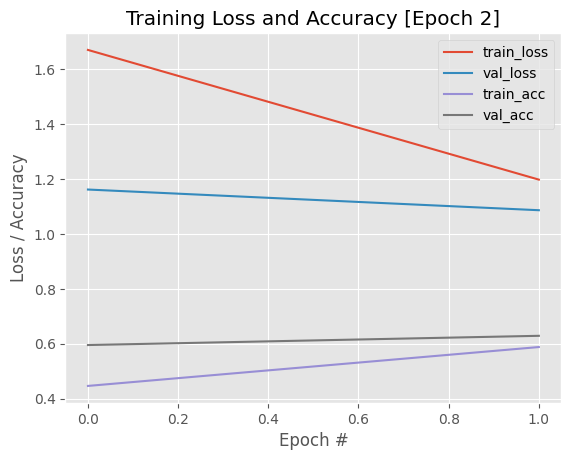

782/782 [==============================] - 10s 12ms/step - loss: 1.1975 - accuracy: 0.5881 - val_loss: 1.0862 - val_accuracy: 0.6290
Epoch 3/100
779/782 [============================>.] - ETA: 0s - loss: 0.9980 - accuracy: 0.6546

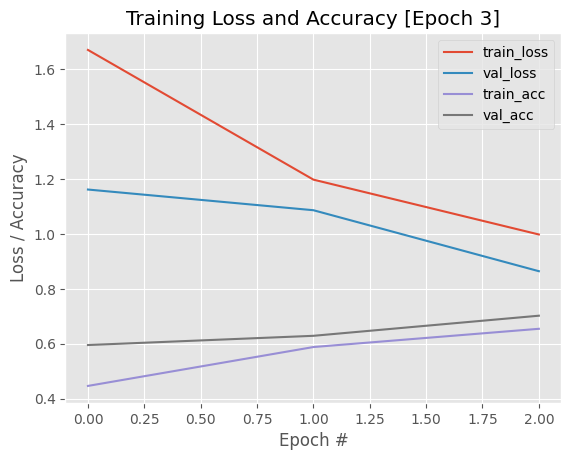

782/782 [==============================] - 10s 12ms/step - loss: 0.9978 - accuracy: 0.6545 - val_loss: 0.8642 - val_accuracy: 0.7022
Epoch 4/100
779/782 [============================>.] - ETA: 0s - loss: 0.8763 - accuracy: 0.6967

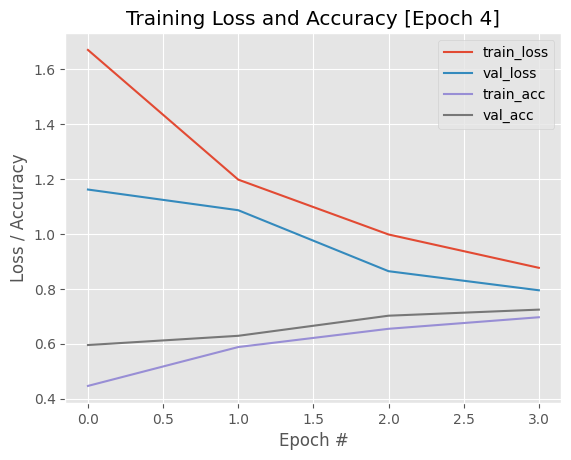

782/782 [==============================] - 10s 13ms/step - loss: 0.8765 - accuracy: 0.6966 - val_loss: 0.7947 - val_accuracy: 0.7243
Epoch 5/100
778/782 [============================>.] - ETA: 0s - loss: 0.7947 - accuracy: 0.7233

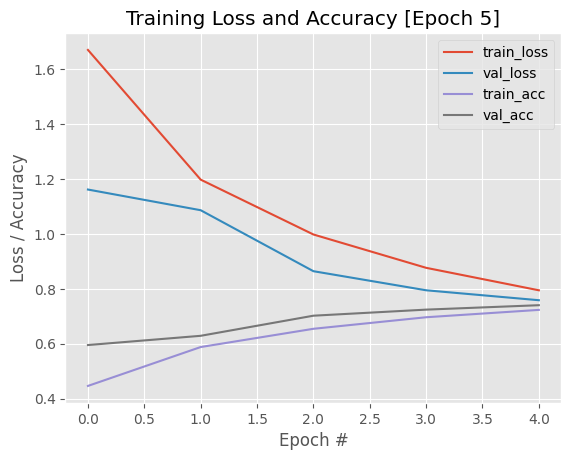

782/782 [==============================] - 10s 12ms/step - loss: 0.7947 - accuracy: 0.7233 - val_loss: 0.7585 - val_accuracy: 0.7404
Epoch 6/100
778/782 [============================>.] - ETA: 0s - loss: 0.7344 - accuracy: 0.7423

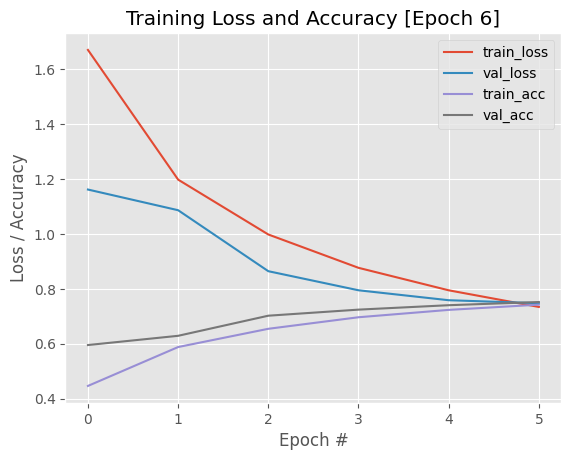

782/782 [==============================] - 10s 13ms/step - loss: 0.7341 - accuracy: 0.7424 - val_loss: 0.7477 - val_accuracy: 0.7520
Epoch 7/100
778/782 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.7595

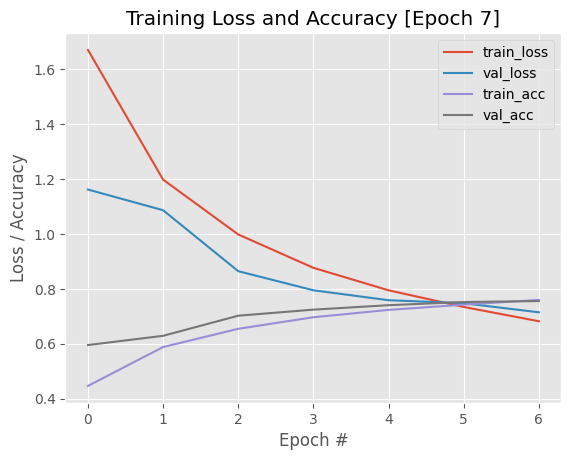

782/782 [==============================] - 10s 13ms/step - loss: 0.6820 - accuracy: 0.7597 - val_loss: 0.7146 - val_accuracy: 0.7555
Epoch 8/100
778/782 [============================>.] - ETA: 0s - loss: 0.6307 - accuracy: 0.7782

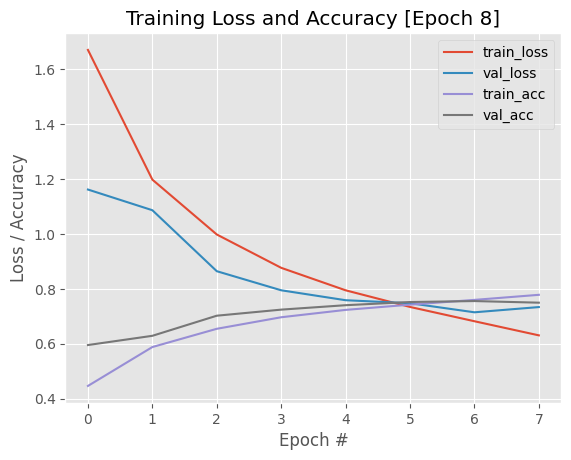

782/782 [==============================] - 10s 13ms/step - loss: 0.6306 - accuracy: 0.7782 - val_loss: 0.7336 - val_accuracy: 0.7496
Epoch 9/100
781/782 [============================>.] - ETA: 0s - loss: 0.5877 - accuracy: 0.7941

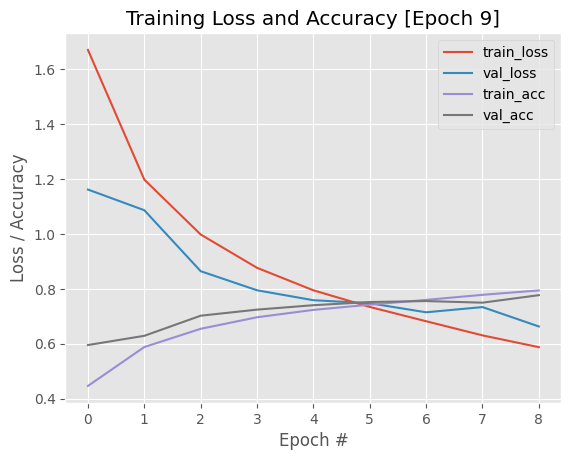

782/782 [==============================] - 10s 13ms/step - loss: 0.5876 - accuracy: 0.7942 - val_loss: 0.6630 - val_accuracy: 0.7770
Epoch 10/100
779/782 [============================>.] - ETA: 0s - loss: 0.5534 - accuracy: 0.8022

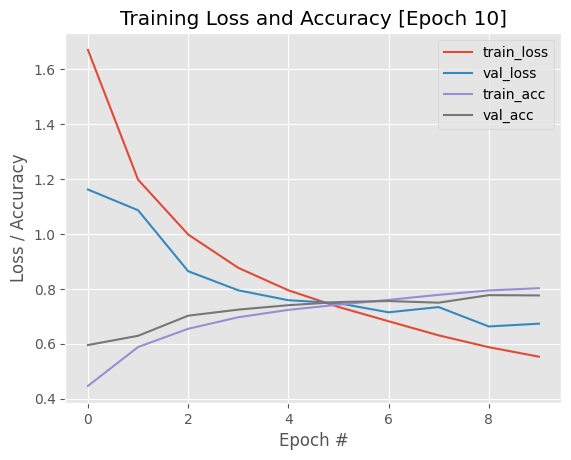

782/782 [==============================] - 10s 13ms/step - loss: 0.5531 - accuracy: 0.8023 - val_loss: 0.6732 - val_accuracy: 0.7760
Epoch 11/100
782/782 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.8147

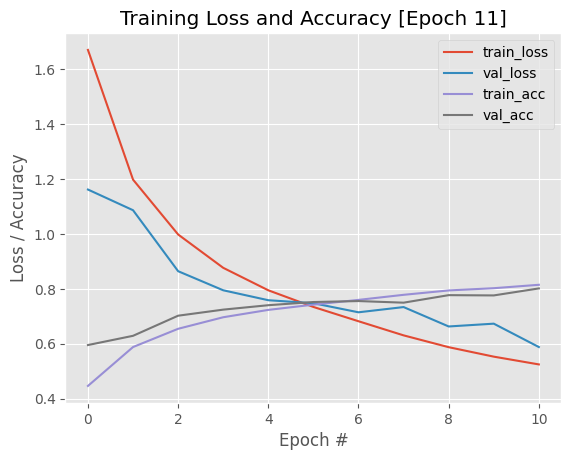

782/782 [==============================] - 10s 13ms/step - loss: 0.5248 - accuracy: 0.8147 - val_loss: 0.5881 - val_accuracy: 0.8015
Epoch 12/100
778/782 [============================>.] - ETA: 0s - loss: 0.4904 - accuracy: 0.8272

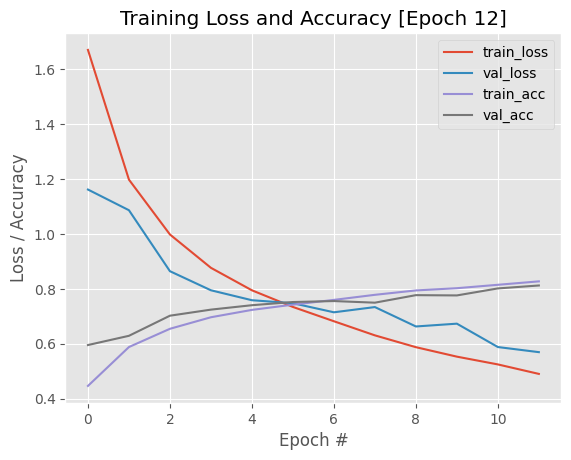

782/782 [==============================] - 10s 13ms/step - loss: 0.4903 - accuracy: 0.8272 - val_loss: 0.5695 - val_accuracy: 0.8122
Epoch 13/100
780/782 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.8347

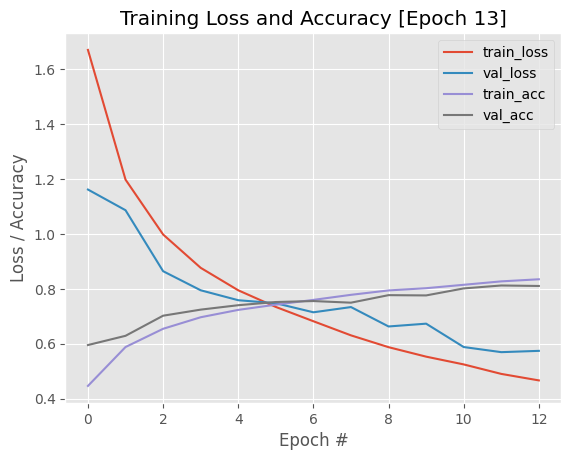

782/782 [==============================] - 10s 13ms/step - loss: 0.4667 - accuracy: 0.8348 - val_loss: 0.5742 - val_accuracy: 0.8104
Epoch 14/100
778/782 [============================>.] - ETA: 0s - loss: 0.4381 - accuracy: 0.8454

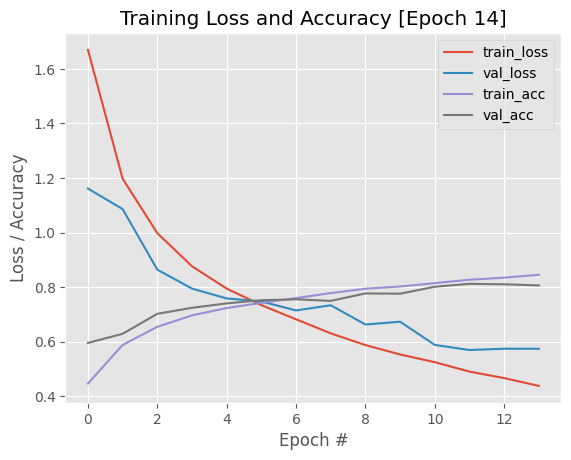

782/782 [==============================] - 11s 15ms/step - loss: 0.4379 - accuracy: 0.8454 - val_loss: 0.5741 - val_accuracy: 0.8063
Epoch 15/100
780/782 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.8539

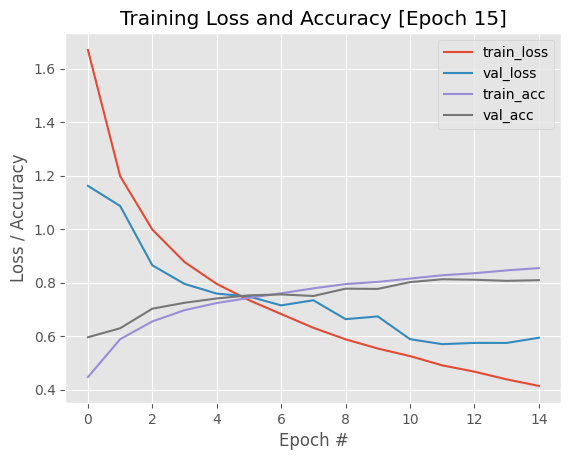

782/782 [==============================] - 10s 13ms/step - loss: 0.4134 - accuracy: 0.8540 - val_loss: 0.5935 - val_accuracy: 0.8087
Epoch 16/100
782/782 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8598

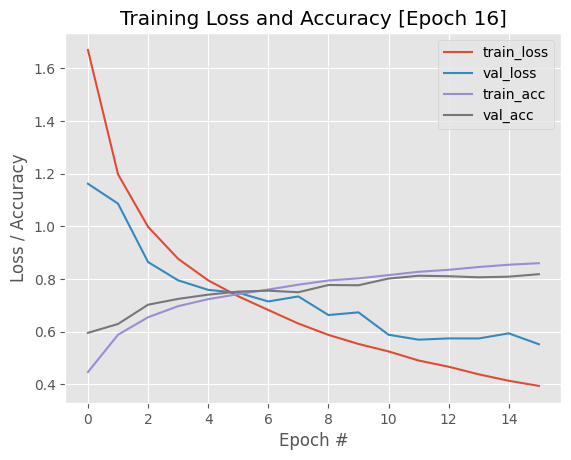

782/782 [==============================] - 10s 13ms/step - loss: 0.3938 - accuracy: 0.8598 - val_loss: 0.5521 - val_accuracy: 0.8181
Epoch 17/100
781/782 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8666

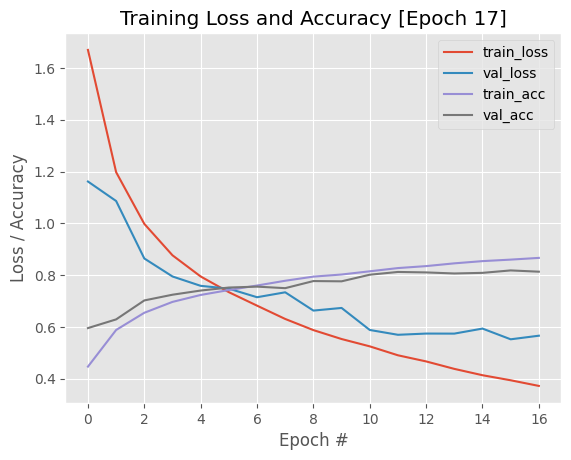

782/782 [==============================] - 10s 13ms/step - loss: 0.3720 - accuracy: 0.8665 - val_loss: 0.5660 - val_accuracy: 0.8132
Epoch 18/100
782/782 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8738

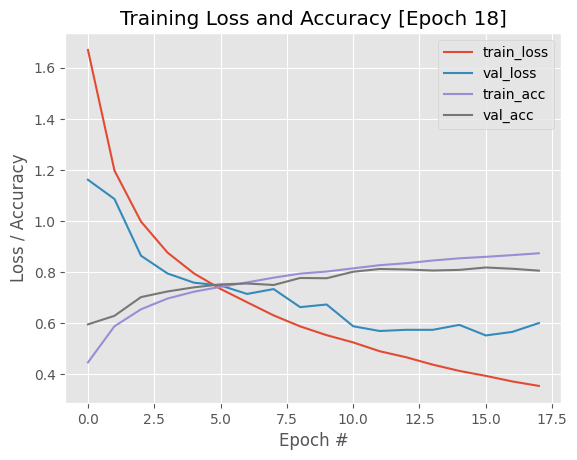

782/782 [==============================] - 11s 14ms/step - loss: 0.3546 - accuracy: 0.8738 - val_loss: 0.6006 - val_accuracy: 0.8057
Epoch 19/100
781/782 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8791

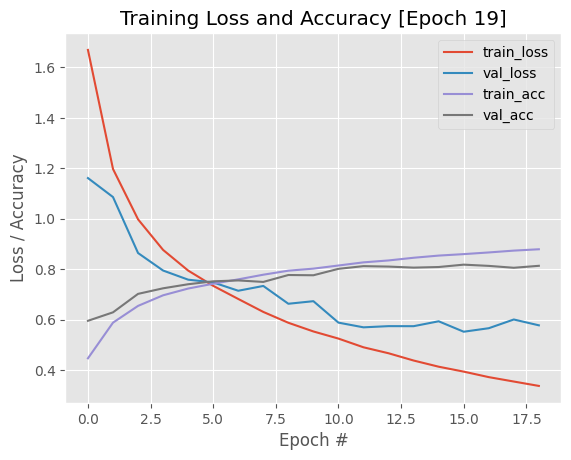

782/782 [==============================] - 10s 13ms/step - loss: 0.3371 - accuracy: 0.8791 - val_loss: 0.5775 - val_accuracy: 0.8135
Epoch 20/100
778/782 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8825

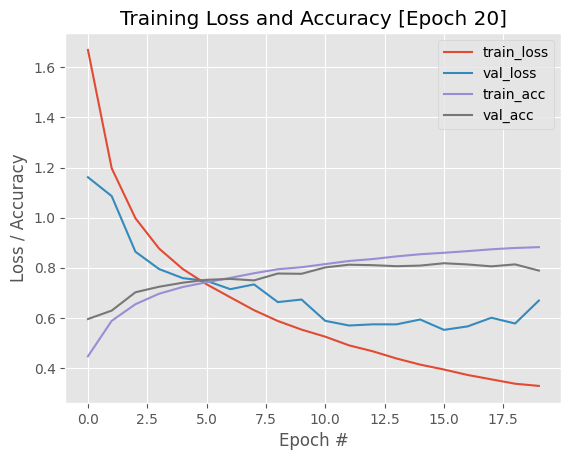

782/782 [==============================] - 10s 13ms/step - loss: 0.3284 - accuracy: 0.8824 - val_loss: 0.6691 - val_accuracy: 0.7887
Epoch 21/100
779/782 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8879

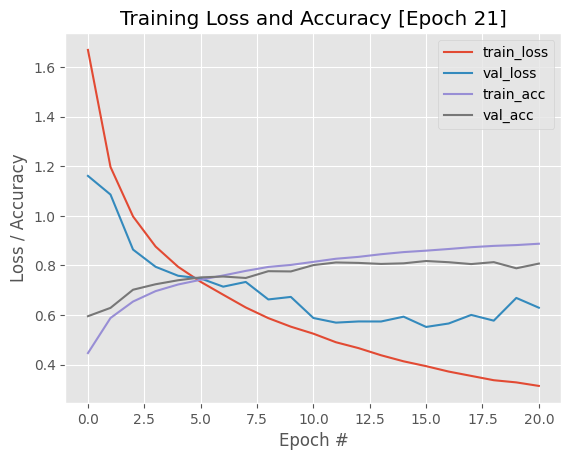

782/782 [==============================] - 10s 13ms/step - loss: 0.3141 - accuracy: 0.8877 - val_loss: 0.6297 - val_accuracy: 0.8076
Epoch 22/100
781/782 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8947

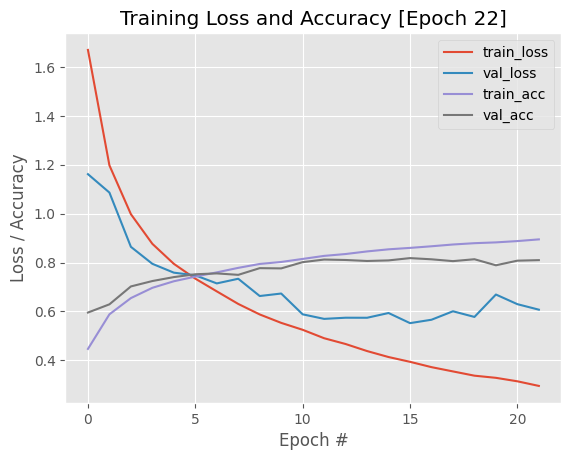

782/782 [==============================] - 10s 13ms/step - loss: 0.2952 - accuracy: 0.8947 - val_loss: 0.6071 - val_accuracy: 0.8098
Epoch 23/100
782/782 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8987

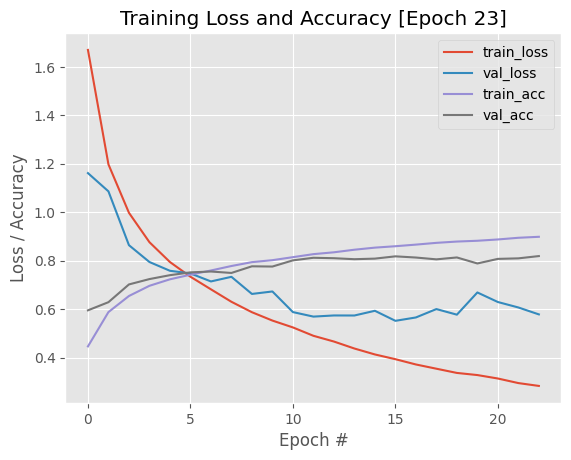

782/782 [==============================] - 11s 14ms/step - loss: 0.2835 - accuracy: 0.8987 - val_loss: 0.5786 - val_accuracy: 0.8192
Epoch 24/100
779/782 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.9028

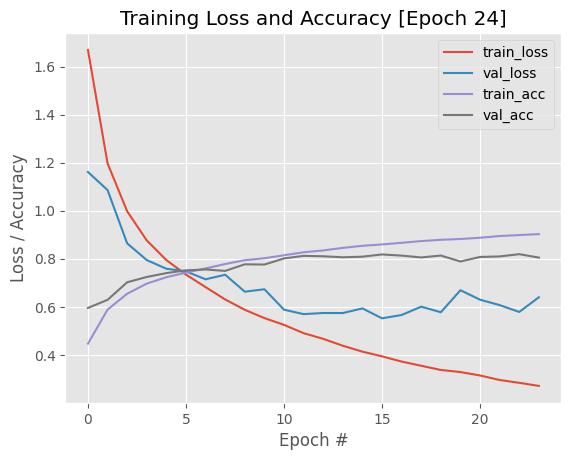

782/782 [==============================] - 10s 13ms/step - loss: 0.2706 - accuracy: 0.9028 - val_loss: 0.6397 - val_accuracy: 0.8050
Epoch 25/100
778/782 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.9014

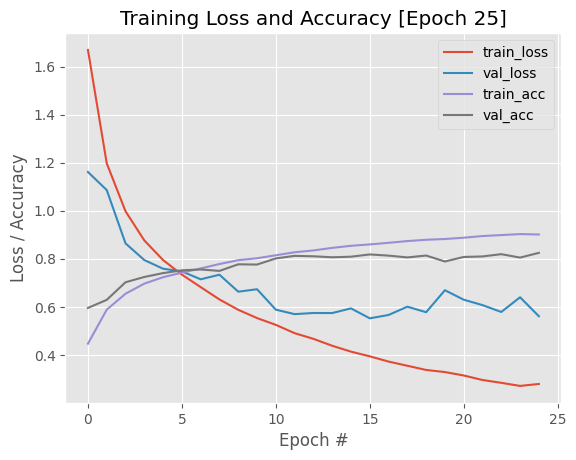

782/782 [==============================] - 10s 13ms/step - loss: 0.2788 - accuracy: 0.9011 - val_loss: 0.5609 - val_accuracy: 0.8247
Epoch 26/100
781/782 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.9099

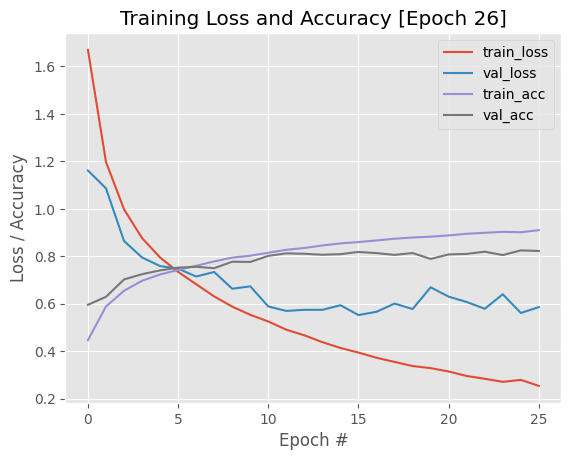

782/782 [==============================] - 11s 13ms/step - loss: 0.2534 - accuracy: 0.9099 - val_loss: 0.5855 - val_accuracy: 0.8222
Epoch 27/100
779/782 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9151

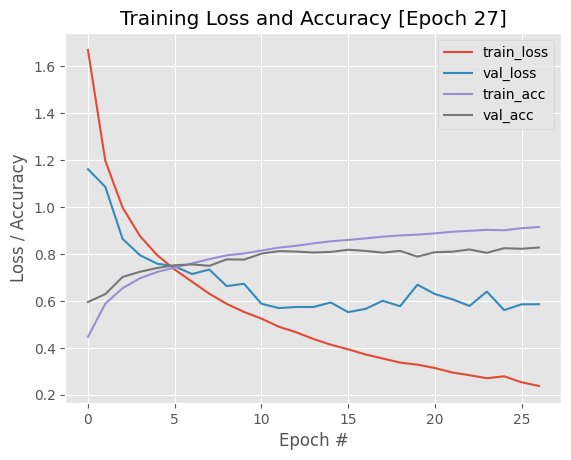

782/782 [==============================] - 11s 14ms/step - loss: 0.2378 - accuracy: 0.9150 - val_loss: 0.5861 - val_accuracy: 0.8276
Epoch 28/100
778/782 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9154

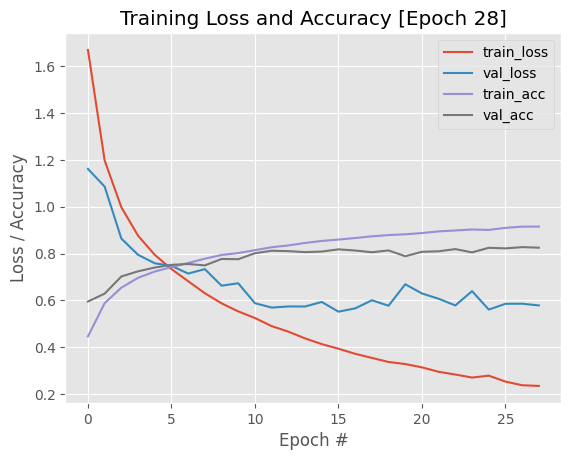

782/782 [==============================] - 10s 13ms/step - loss: 0.2349 - accuracy: 0.9154 - val_loss: 0.5787 - val_accuracy: 0.8252
Epoch 29/100
781/782 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.9190

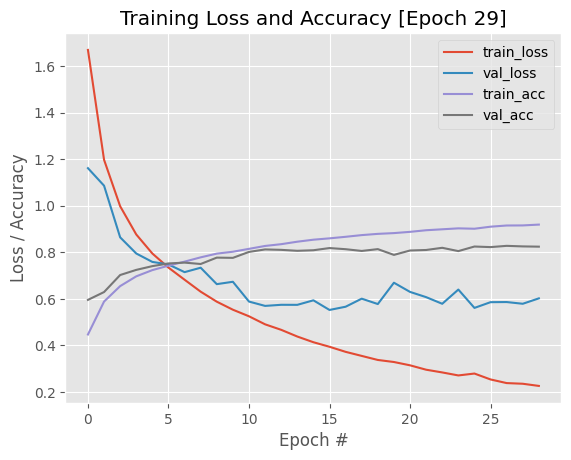

782/782 [==============================] - 11s 14ms/step - loss: 0.2256 - accuracy: 0.9189 - val_loss: 0.6019 - val_accuracy: 0.8241
Epoch 30/100
781/782 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9232

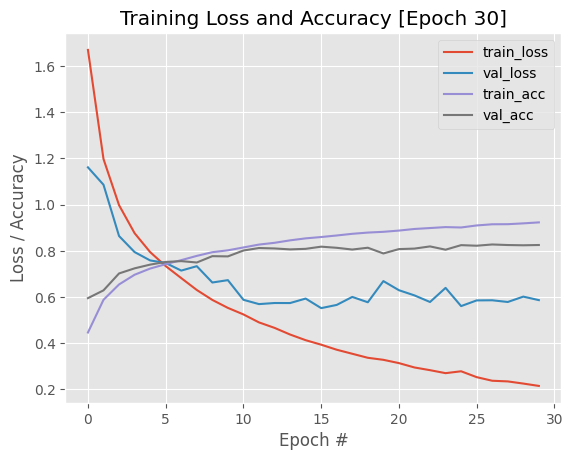

782/782 [==============================] - 11s 14ms/step - loss: 0.2154 - accuracy: 0.9232 - val_loss: 0.5867 - val_accuracy: 0.8253
Epoch 31/100
779/782 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9251

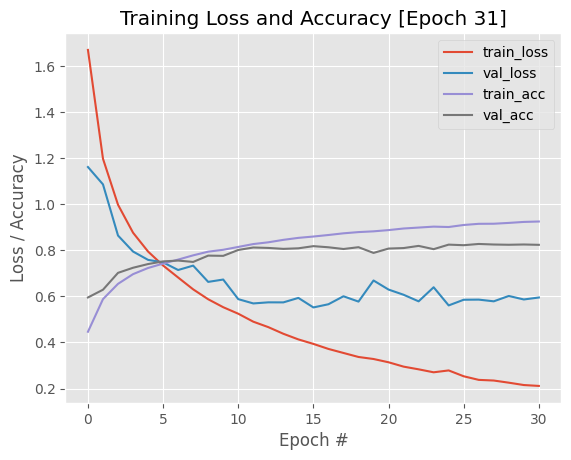

782/782 [==============================] - 11s 14ms/step - loss: 0.2115 - accuracy: 0.9250 - val_loss: 0.5952 - val_accuracy: 0.8238
Epoch 32/100
780/782 [============================>.] - ETA: 0s - loss: 0.2098 - accuracy: 0.9255

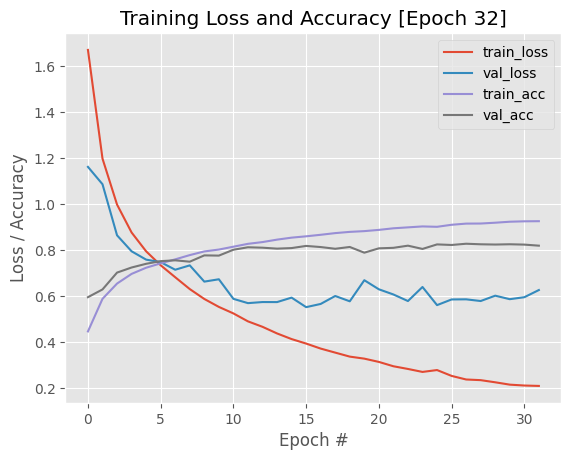

782/782 [==============================] - 11s 14ms/step - loss: 0.2098 - accuracy: 0.9255 - val_loss: 0.6264 - val_accuracy: 0.8192
Epoch 33/100
650/782 [=======================>......] - ETA: 1s - loss: 0.1935 - accuracy: 0.9321

KeyboardInterrupt: ignored

In [6]:
json_path = "/content/"+f"{os.getpid()}.json"

callbacks = [TrainingMonitor(json_path=json_path)]
print("[INFO] training network...")
%matplotlib inline
model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=100, callbacks=callbacks, verbose=1)